In [1]:
!pip install -q mpl_sankey

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import textnets as tn
import pandas as pd
from mpl_sankey import sankey

In [4]:
tn.params["autodownload"] = True

In [5]:
net = tn.Textnet(tn.Corpus(tn.examples.digitalisierung, lang="de").noun_phrases())

In [6]:
def sankey_data(textnet: tn.Textnet) -> pd.DataFrame:
    """
    Turn a textnet into a dataframe with a row for each term-doc pair and the following columns:
    * Weight (tf-idf)
    * Group (doc's cluster in document-to-document projection)
    * Doc (document label)
    * Term (the term)
    * Topic (term's cluster in the term-to-term projection)
    """
    lookup = dict(zip(textnet.nodes["id"], textnet.nodes.indices))
    to_roman = {1: "i", 2: "ii", 3: "iii", 4: "iv", 5: "v"}
    def weight_doc_term(textnet):       
        for node in [n for n, typ in zip(textnet.nodes, textnet.node_types) if not typ]:
            for neighbor, edge in zip(node.neighbors(), node.out_edges()):
                yield [edge["weight"], node["id"], neighbor["id"]]
    def group_doc(textnet):
        p1 = textnet.project(node_type="doc")
        for node, cluster in zip(p1.nodes, p1.clusters.membership):
            if node.neighbors():
                yield [f"{to_roman[cluster+1]}", node["id"]]
    def term_topic(textnet):
        p2 = textnet.project(node_type="term")
        for node, cluster in zip(p2.nodes, p2.clusters.membership):
            if node.neighbors():
                yield [node["id"], f"{cluster+1}"]
    gd = pd.DataFrame(group_doc(textnet), columns=["group", "doc"]).set_index("doc")
    wdt = pd.DataFrame(weight_doc_term(textnet), columns=["weight", "doc", "term"])
    tt = pd.DataFrame(term_topic(textnet), columns=["term", "topic"]).set_index("term")
    joined = wdt.join(gd, on="doc").join(tt, on="term")
    sorted_terms = joined.groupby("term").agg({"weight": "sum", "group": "first"})\
        .sort_values(["group", "weight"], ascending=[True, False]).index.tolist()
    terms_type = pd.CategoricalDtype(sorted_terms, ordered=True)
    joined["term"] = joined["term"].astype(terms_type)
    sorted_docs = joined.groupby("doc").agg({"weight": "sum", "group": "first"})\
        .sort_values(["group", "weight"], ascending=[True, False]).index.tolist()
    docs_type = pd.CategoricalDtype(sorted_docs, ordered=True)
    joined["doc"] = joined["doc"].astype(docs_type)
    return joined[["weight", "group", "doc", "term", "topic"]]

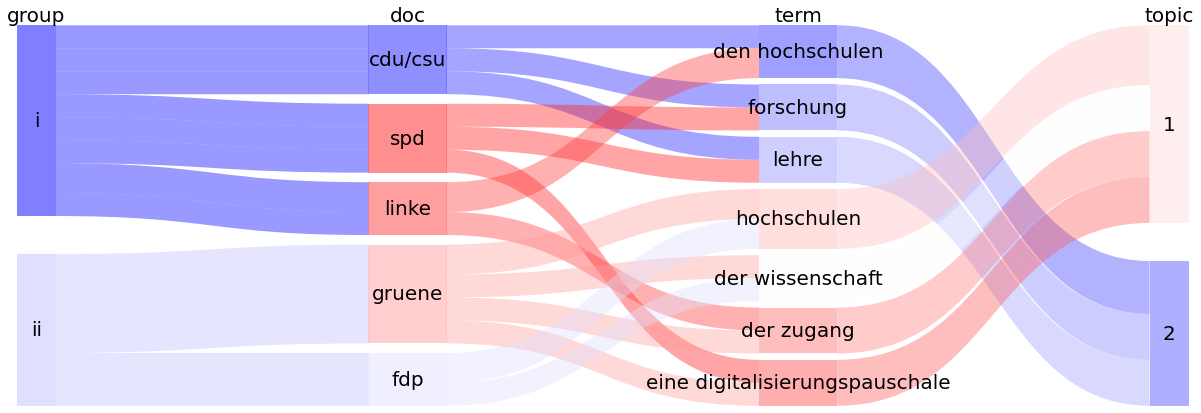

In [7]:
plt.figure(figsize=(21, 7))

sankey(sankey_data(net),
       cmap=plt.get_cmap('bwr'),
       sort_flows_by_nodes=True)